In [7]:
%load_ext autoreload
%autoreload 2
import torch
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline
relPath = "../../"
import sys
sys.path.append(relPath)
from mm.printing import *
from mm.neural.neural import *
from layers import *
from network import *
from neural import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
initLogging("Common init")

dvc = torch.device("cpu")
log("device", dvc.type)

Common init:             -------------------------- 2023-07-26 16:53:47
device:                  cpu


In [9]:
logSection("Prepare data")

filePath = relPath + "data/names.txt"
log("filePath", filePath)

ldr = loadData(filePath)
printDataInfo(ldr)

Prepare data:            -------------------------- 2023-07-26 16:53:47
filePath:                ../../data/names.txt
First few words:         ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Words counts:            32033
Vocabulary:              ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi:                    {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos:                    {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
Vocabulary + end length: 27
random probability:      3.2958


In [10]:
logSection("Prepare dataset")

wordShufflingSeed = 42
log("Words shuffling seed", wordShufflingSeed)
random.seed(wordShufflingSeed)
random.shuffle(ldr.words)

contextSize = 3
log("Context size", contextSize)

ds = buildDataSet(ldr, contextSize, 0.8, 0.9, torch.int64, dvc)

Prepare dataset:         -------------------------- 2023-07-26 16:53:47
Words shuffling seed:    42
Context size:            3
Data dtype:              torch.int64
Training ratio:          0.8
Validation ratio:        0.9
Training:                length 25626 shape [182625, 3] ['yuheng', 'diondre', 'xavien']
Validation:              length 3203 shape [22655, 3] ['amay', 'aytana', 'jenevi']
Test:                    length 3204 shape [22866, 3] ['mustafa', 'reuben', 'kahlel']


In [11]:
logSection("Build network")

embeddingDims = 10
log("Embedding dimensions", embeddingDims)

hiddenLayerSize = 100
log("Hidden layers size", hiddenLayerSize)

learningSeed = 2147483647
log("Learning seed", learningSeed)
g = torch.Generator(device=dvc).manual_seed(learningSeed)

dtype = torch.float
log("dtype", dtype)

np = makeNetwork(g, len(ldr.stoi), embeddingDims, contextSize, hiddenLayerSize, dtype, dvc)
printNetworkInfo(np)
    
@torch.no_grad()
def trLoss(): return getLoss(np, np.C[ds.tr.x], ds.tr.y)

@torch.no_grad()
def valLoss(): return getLoss(np, np.C[ds.val.x], ds.val.y)

@torch.no_grad()
def tstLoss(): return getLoss(np, np.C[ds.tst.x], ds.tst.y)

def getLosses() -> Losses:
    l = Losses()
    l.tr = trLoss()
    l.val = valLoss()
    l.tst = tstLoss()
    return l

def logLosses():
    losses = getLosses()
    l1 = f"{losses.tr.loss.item():>10.4f}"
    l2 = f"{losses.val.loss.item():>10.4f}"
    l3 = f"{losses.tst.loss.item():>10.4f}"
    logSimple(f"{l1} {l2} {l3}")

Build network:           -------------------------- 2023-07-26 16:53:48
Embedding dimensions:    10
Hidden layers size:      100
Learning seed:           2147483647
dtype:                   torch.float32
Network Layers Structure:
  Linear 18:             [30, 100]
  BatchNorm1d 19:        [100], [100]
  Tanh 20:               
  Linear 21:             [100, 100]
  BatchNorm1d 22:        [100], [100]
  Tanh 23:               
  Linear 24:             [100, 100]
  BatchNorm1d 25:        [100], [100]
  Tanh 26:               
  Linear 27:             [100, 100]
  BatchNorm1d 28:        [100], [100]
  Tanh 29:               
  Linear 30:             [100, 100]
  BatchNorm1d 31:        [100], [100]
  Tanh 32:               
  Linear 33:             [100, 27]
  BatchNorm1d 34:        [27], [27]
Parameters Count:        47024


In [12]:
logSection("Training")

trainingBatchSize = 32
log("Training batch size", trainingBatchSize)

trXLength = ds.tr.x.shape[0]
trainingSteps = (trXLength // trainingBatchSize) + 1
log ("Training steps: ", trainingSteps)

repeats = 36
log("Repeats",repeats)

maxIteration = 1
log("Max iterations", maxIteration)

maxLr = 0.1
log("Max learning rate", maxLr)

minLr = 0.1
log("Min learning rate", minLr)

actualIterations = min(maxIteration, repeats * math.ceil(trXLength / trainingBatchSize))
log("Actual iterations", actualIterations)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = True;

lrAtIx: list[float] = []
stepIx: list[int] = []
lossAtIx: list[float] = []
logLossAtIx: list[float] = []
ud = []
up = UpdateNetResult()
fr = ForwardPassResult()
fr.loss = torch.tensor(0)
stopped = False
i = 0
for repeat in range(repeats):
    
    if stopped:
        break;

    logSimple(f"{repeat:>3}, {i:>7} losses: {fr.loss.item():>10.4f}   ", end="")
    #logLosses()

    for start in range(0, trXLength, trainingBatchSize):

        if i >= maxIteration:
            stopped = True
            log("Stopped at max iteration")
            break;
        
        end = min(start + trainingBatchSize, trXLength)
        miniBatchIxs = torch.randint(0, trXLength, (trainingBatchSize,), generator=g, device=dvc)
        fr = forwardPass(np, ds.tr.x, ds.tr.y, miniBatchIxs)
        backwardPass(np.layers, np.parameters, fr.loss)
        up = updateNet(np.parameters, i, actualIterations, maxLr, minLr)
        lrAtIx.append(up.learningRate)
        stepIx.append(i)
        lossAtIx.append(fr.loss.item())
        logLossAtIx.append(fr.loss.log10().item())
        with torch.no_grad():
            ud.append([((up.learningRate * not_null(p.grad)).std() / p.data.std()).log10().item() for p in np.parameters])

        i += 1

logSimple(f"Final losses: {fr.loss.item():>17.4f}   ", end="")
#logLosses()

log("Embedding shape", fr.emb.shape)
log("Logits shape", fr.logits.shape)

for l in np.layers:
    if isinstance(l, BatchNorm1d):
        l.training = False;

Training:                -------------------------- 2023-07-26 16:53:48
Training batch size:     32
Training steps: :        5708
Repeats:                 36
Max iterations:          1
Max learning rate:       0.1
Min learning rate:       0.1
Actual iterations:       1
  0,       0 losses:     0.0000   Stopped at max iteration:
Final losses:            3.2958   Embedding shape:         [32, 3, 10]
Logits shape:            [32, 27]


In [13]:
logSection("Introspection")

Introspection:           -------------------------- 2023-07-26 16:53:48


C:\Users\m.minich\AppData\Local\Temp\ipykernel_18000\1265342105.py:3: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(min(lrAtIx), max(lrAtIx))


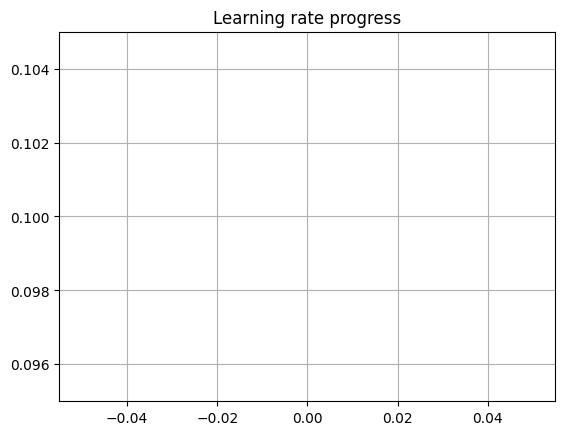

Min learning rate:       0.1
Max learning rate:       0.1


In [14]:
plt.plot(range(len(lrAtIx)), lrAtIx, "black")
plt.title('Learning rate progress');
plt.ylim(min(lrAtIx), max(lrAtIx))
plt.grid(True)
plt.show()
log("Min learning rate", min(lrAtIx))
log("Max learning rate", max(lrAtIx))


  Tanh 20:               mean: +0.01485, std: +0.66596, saturated: 0.38
  Tanh 23:               mean: +0.02983, std: +0.69877, saturated: 0.00
  Tanh 26:               mean: +0.02962, std: +0.72418, saturated: 0.00
  Tanh 29:               mean: +0.03161, std: +0.73649, saturated: 0.00
  Tanh 32:               mean: +0.03399, std: +0.74163, saturated: 0.00


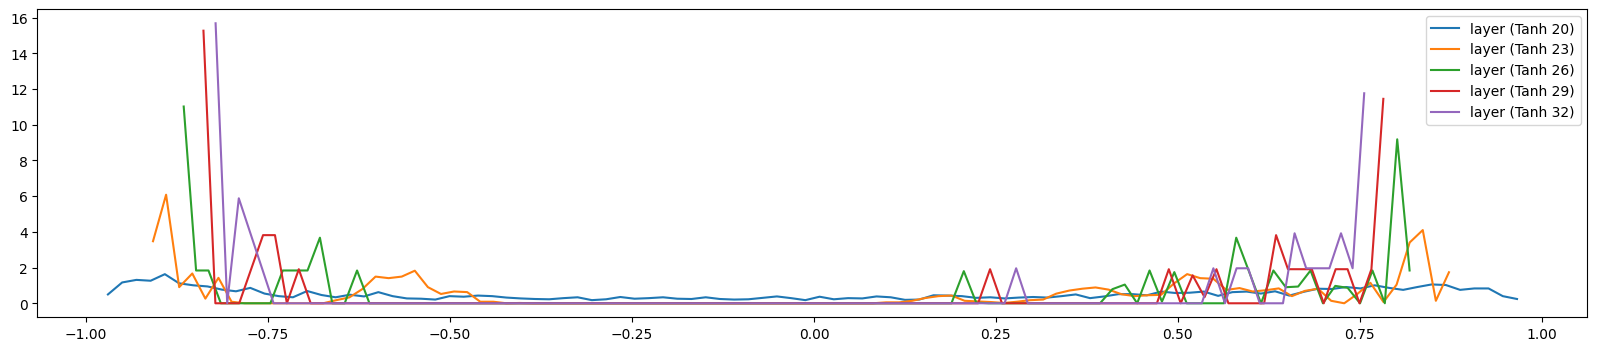

In [15]:
plotActivationsDistribution(np.layers, Tanh)

layer 2 (      Tanh): mean +0.01, std 0.67, saturated: 0.38%
layer 5 (      Tanh): mean +0.03, std 0.70, saturated: 0.00%
layer 8 (      Tanh): mean +0.03, std 0.72, saturated: 0.00%
layer 11 (      Tanh): mean +0.03, std 0.74, saturated: 0.00%
layer 14 (      Tanh): mean +0.03, std 0.74, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

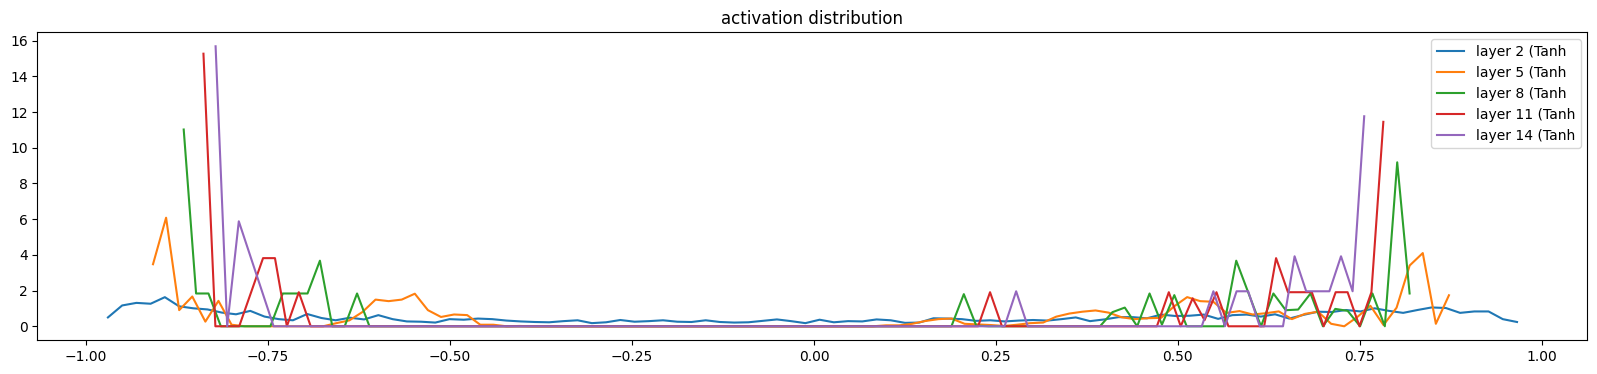

In [16]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(np.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.01, std 0.67, saturated: 0.38%
layer 5 (      Tanh): mean +0.03, std 0.70, saturated: 0.00%
layer 8 (      Tanh): mean +0.03, std 0.72, saturated: 0.00%
layer 11 (      Tanh): mean +0.03, std 0.74, saturated: 0.00%
layer 14 (      Tanh): mean +0.03, std 0.74, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

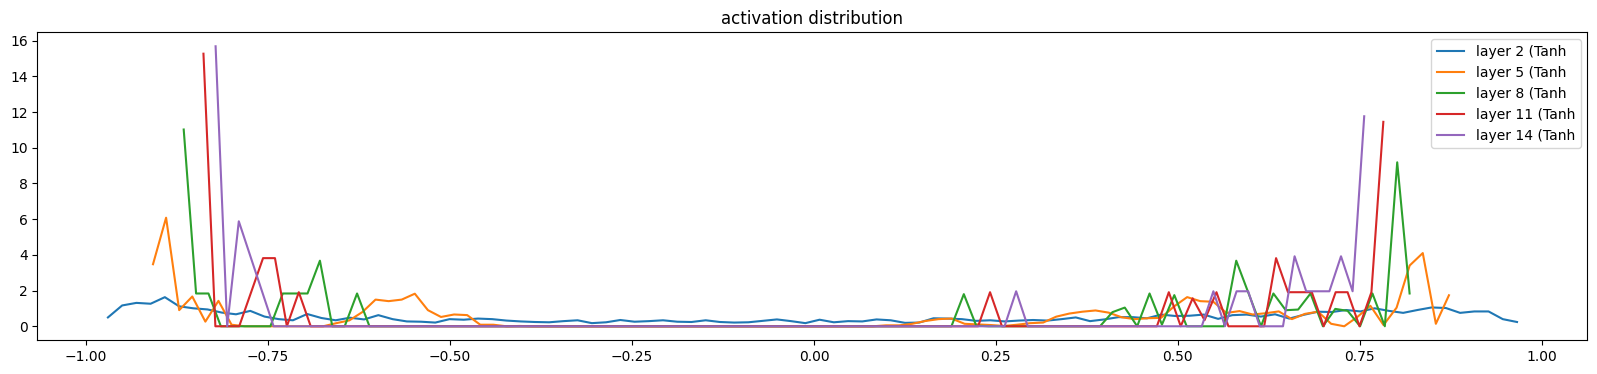

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(np.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


  Linear 18:             mean: +1.37967, std: +0.22520, saturated: 96.62
  Linear 21:             mean: +0.07477, std: +3.03402, saturated: 96.81
  Linear 24:             mean: +0.14939, std: +3.50247, saturated: 97.59
  Linear 27:             mean: +0.14770, std: +3.61711, saturated: 99.97
  Linear 30:             mean: +0.15865, std: +3.70216, saturated: 100.00
  Linear 33:             mean: +0.17071, std: +3.73110, saturated: 100.00


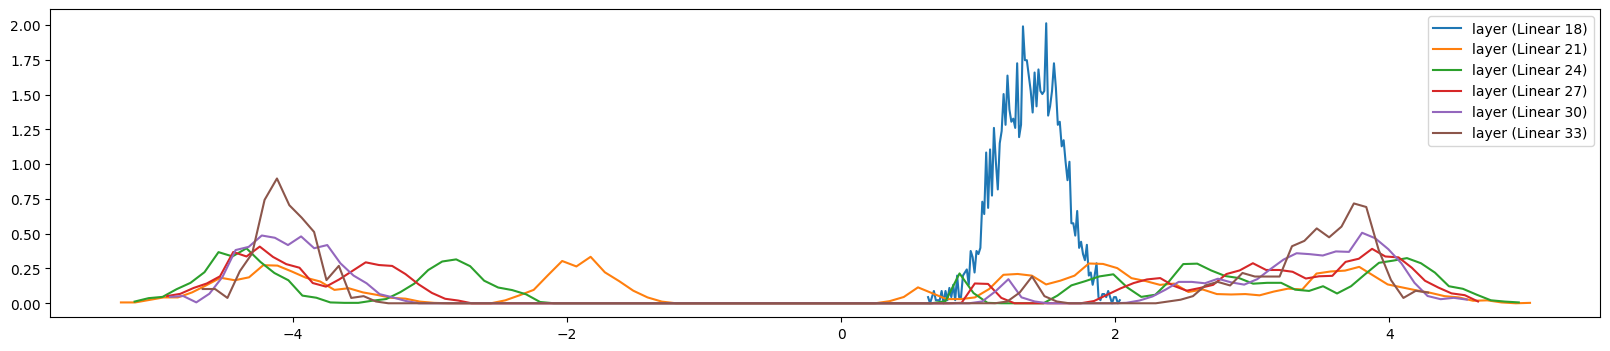

In [18]:
plotActivationsDistribution(np.layers, Linear)
#plotActivationsDistribution(np.layers, LinearWithBias)

Activation distribution - Tanh (Grad)
  Tanh 20:               mean: +0.00000, std: +0.00000
  Tanh 23:               mean: -0.00000, std: +0.00000
  Tanh 26:               mean: +0.00000, std: +0.00000
  Tanh 29:               mean: -0.00000, std: +0.00000
  Tanh 32:               mean: -0.00000, std: +0.00002


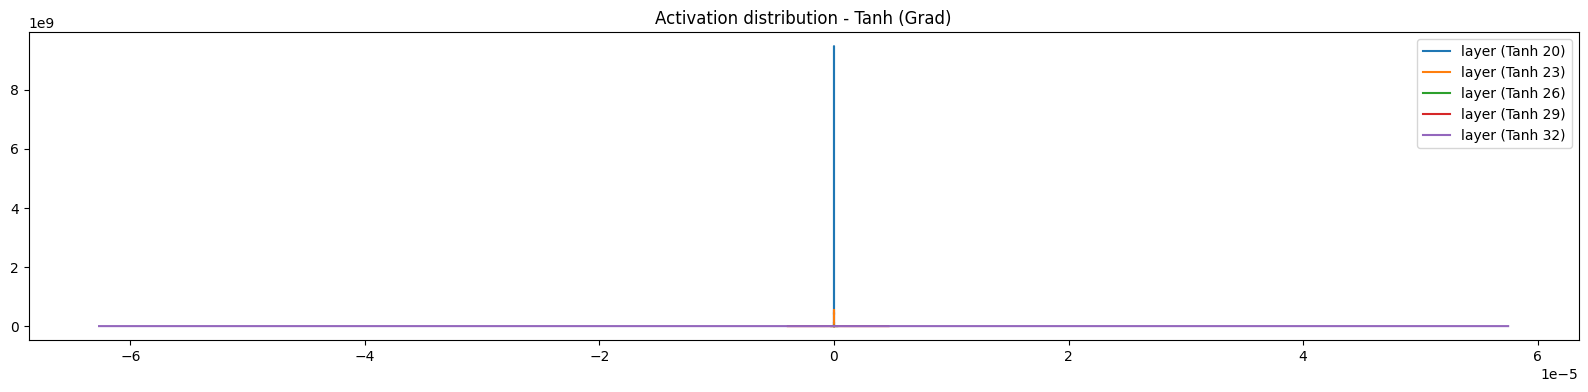

In [19]:
plotActivationsDistribution(np.layers, Tanh, useGrad=True)

Activation distribution - Linear (Grad)
  Linear 18:             mean: -0.00000, std: +0.00000
  Linear 21:             mean: -0.00000, std: +0.00000
  Linear 24:             mean: -0.00000, std: +0.00000
  Linear 27:             mean: +0.00000, std: +0.00000
  Linear 30:             mean: +0.00000, std: +0.00000
  Linear 33:             mean: +0.00000, std: +0.00015
Activation distribution - LinearWithBias (Grad)


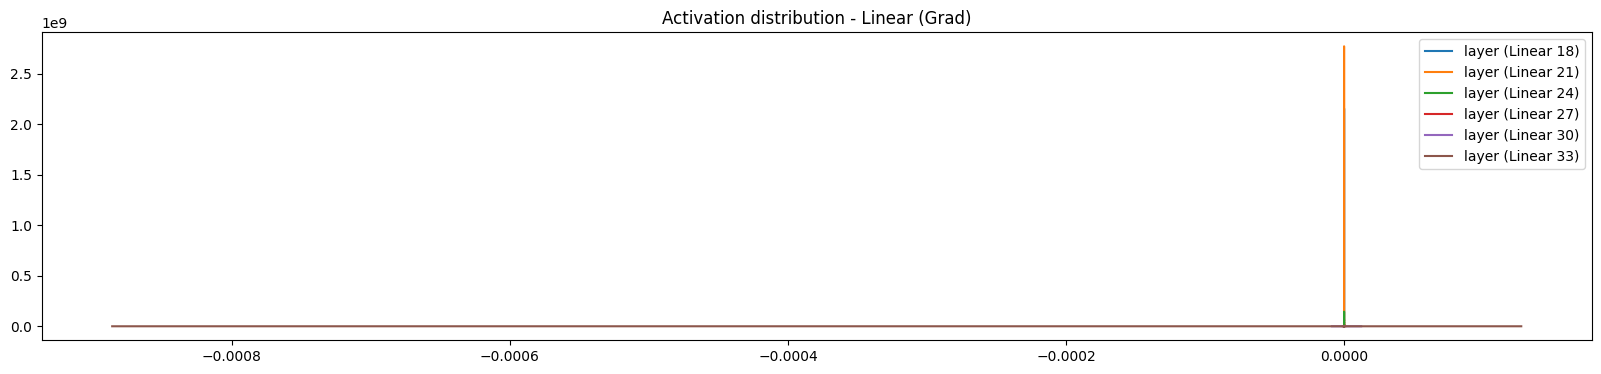

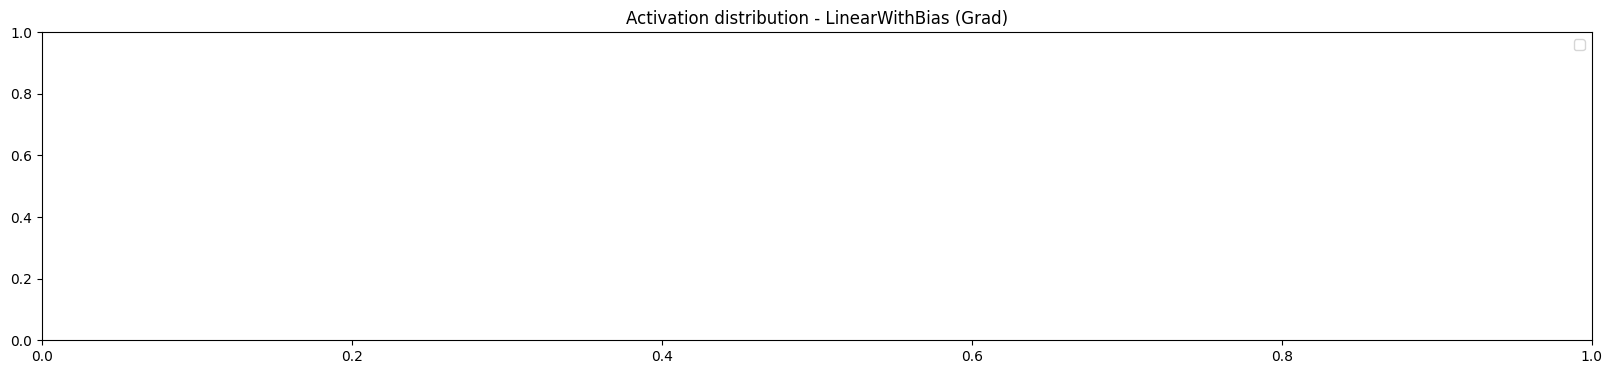

In [20]:
plotActivationsDistribution(np.layers, Linear, useGrad=True)
plotActivationsDistribution(np.layers, LinearWithBias, useGrad=True)

Gradient weights distribution - 
  C
    Weight:                [27, 10], mean: -0.00000, std: 2.327004e-09, data ratio: 8.309851e-09
  Linear 18
    Weight:               [30, 100], mean: +0.00000, std: 1.482375e-09, data ratio: 2.822308e-08
  Linear 21
    Weight:              [100, 100], mean: -0.00000, std: 1.477195e-09, data ratio: 5.106895e-08
  Linear 24
    Weight:              [100, 100], mean: -0.00000, std: 1.469118e-09, data ratio: 5.097829e-08
  Linear 27
    Weight:              [100, 100], mean: -0.00000, std: 1.352552e-09, data ratio: 4.672856e-08
  Linear 30
    Weight:              [100, 100], mean: -0.00000, std: 1.330892e-09, data ratio: 4.626413e-08
  Linear 33
    Weight:               [100, 27], mean: +0.00000, std: 2.876431e-09, data ratio: 9.867027e-08


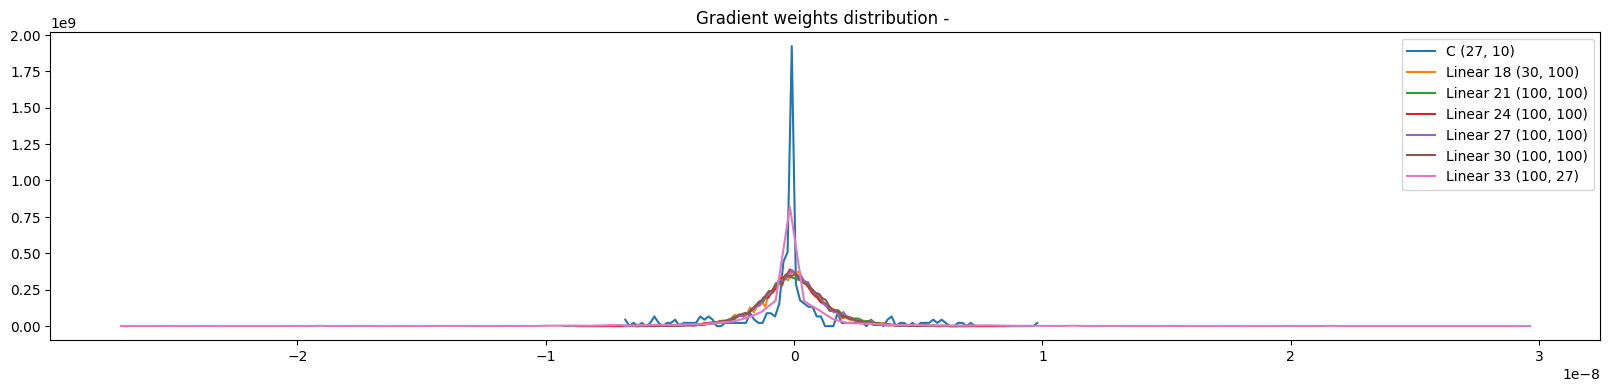

In [21]:
plotGradWeightsDistribution(np)

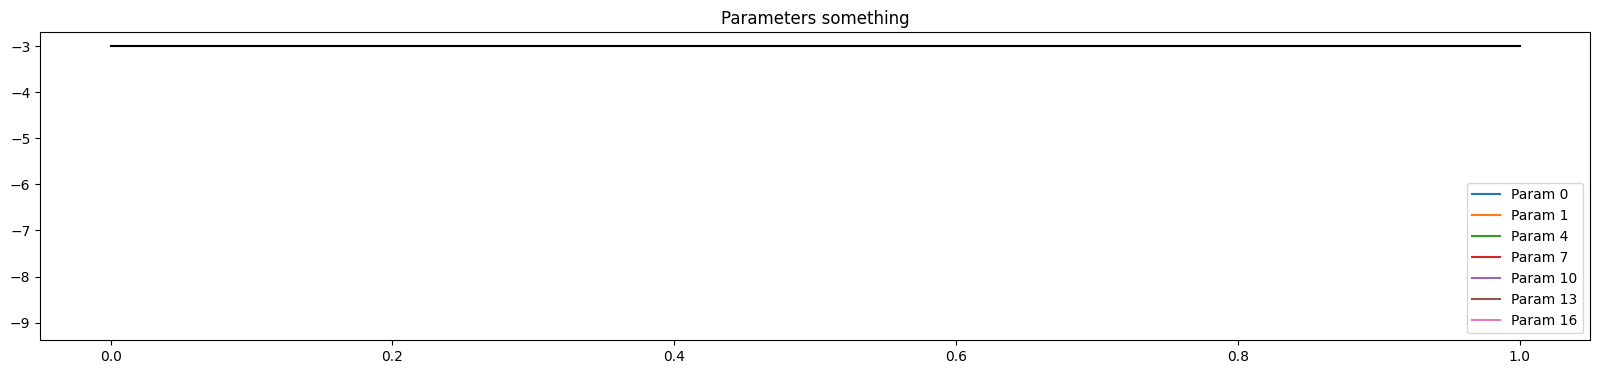

In [22]:
title = "Parameters something"
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(np.parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append("Param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k") # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title(title);

In [23]:
#plt.figure(figsize=(20,10))
#plt.imshow(fr.h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [24]:
logSection("Sampling")

samplingSeed = learningSeed + 10
gSampling = torch.Generator(device=dvc).manual_seed(samplingSeed)
log("samplingSeed", samplingSeed)

maxSampleLength = 50
log("maxSampleLength", maxSampleLength)

Sampling:                -------------------------- 2023-07-26 16:53:52
samplingSeed:            2147483657
maxSampleLength:         50


In [25]:
samples = []#sampleMany(np, gSampling, contextSize, ldr.itos, 20, maxSampleLength)
for s in samples:
    logSimple(f"{''.join(s.values):<21}{(s.prob * 10000):>4.0f}: ", end="")
    for p in s.probs:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

In [26]:
logSection("Probabilities")

def printProb(txt: str):
    ps = #calcProb(np, txt, contextSize, ldr.stoi)
    op = calcOneProb(ps)
    logSimple(f"{txt:<25}{(op * 10000):<7.0f}: ", end="")
    for p in ps:
        logSimple(f"{(p / (1 / 27) * 10):.0f} ", end="")
    logSimple()

printProb('.')
printProb('m.')
printProb('mi.')
printProb('mic.')
printProb('mich.')
printProb('micha.')
printProb('michal.')
printProb('michael.')
printProb('michaela.')
printProb('michaella.')
printProb('michel.')
printProb('michalx.')
printProb('michalxx.')
printProb('michalxxx.')
printProb('martin.')
printProb('andrej.')
printProb('andrey.')
printProb('joey.')
printProb('james.')
printProb('xin.')
printProb('maxim.')
printProb('alex.')
printProb('alexa.')

SyntaxError: invalid syntax (1599778436.py, line 4)

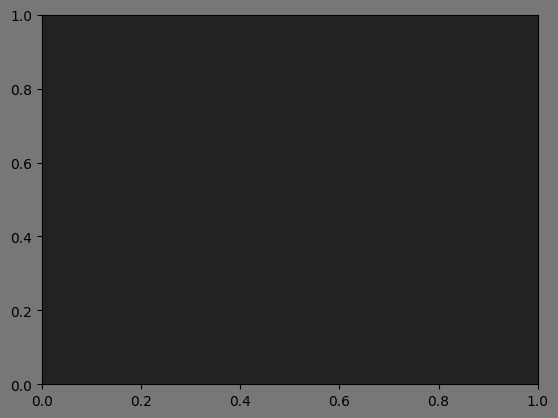

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
#ax.plot(lrAtIx, lossAtIx)
plt.show()

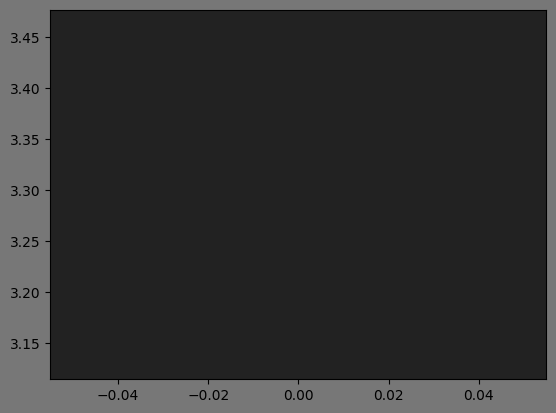

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, lossAtIx)
plt.show()

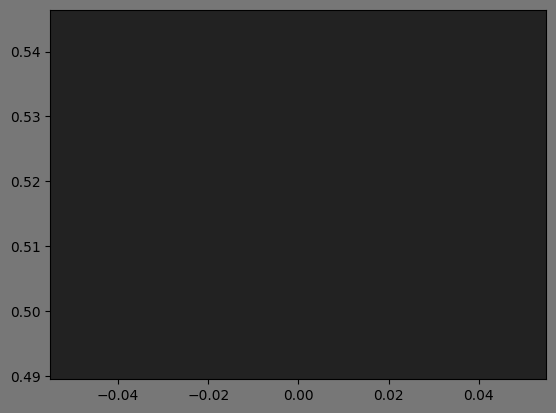

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor("#777777")
ax.set_facecolor("#222222")
ax.plot(stepIx, logLossAtIx)
plt.show()

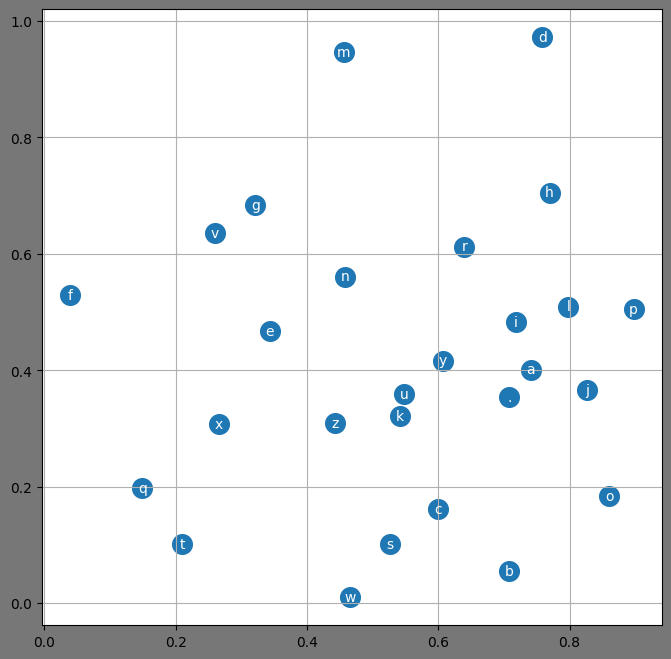

In [ ]:
dim = 0
fig = plt.figure(figsize=(8,8))
fig.set_facecolor("#777777")
sc = plt.scatter(np.C[:, dim].data, np.C[:,dim + 1].data, s=200)
for i in range(np.C.shape[0]):
    plt.text(np.C[i, dim].item(), np.C[i, dim + 1].item(), ldr.itos[i], ha="center", va="center", color="white")
plt.grid()